In [97]:
import torch
from torchvision import datasets, transforms
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import nbformat
import os
import collections

PRINT_IMG = True
AUGMENT_DATASET = False
TRANSFORM_DATASET = False

OPTIMIZER = 'ADAM'

### Hyperparameters ###
BATCH_SIZE = 128
LEARNING_RATE = 0.001
MOMENTUM = 0.9
EPOCHS = 10

In [2]:
def create_image_pairs(dataset):
    image_pairs = []
    labels = []

    max_size_class = len(dataset) // 3  # Limita il numero massimo di campioni per ciascuna classe
    count_class_0 = 0  # Contatore per la classe A > B
    count_class_1 = 0  # Contatore per la classe A < B
    count_class_2 = 0  # Contatore per la classe A = B
    i = 0
    
    # Continua finché tutte le classi non sono bilanciate
    while count_class_0 < max_size_class or count_class_1 < max_size_class or count_class_2 < max_size_class:
        img_A, label_A = dataset[i]

        class_busy = True
        while class_busy:  # Cerca una relazione valida che non sia satura
            idx_B = random.randint(0, len(dataset) - 1)
            img_B, label_B = dataset[idx_B]

            # Determina la relazione tra le etichette
            if label_A > label_B:
                relation_label = 0  # A > B
            elif label_A < label_B:
                relation_label = 1  # A < B
            else:
                relation_label = 2  # A = B

            # Verifica se la classe ha già raggiunto il limite massimo
            if relation_label == 0 and count_class_0 < max_size_class:
                count_class_0 += 1
                class_busy = False
            elif relation_label == 1 and count_class_1 < max_size_class:
                count_class_1 += 1
                class_busy = False
            elif relation_label == 2 and count_class_2 < max_size_class:
                count_class_2 += 1
                class_busy = False

        # Aggiungi la coppia solo se la classe non ha raggiunto il limite massimo
        image_pairs.append((img_A, img_B))
        labels.append(relation_label)
        i += 1

    return image_pairs, labels


In [3]:
# Dataset personalizzato per gestire le coppie di immagini
class MNISTPairDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        # Crea le coppie di immagini e le etichette corrispondenti
        self.image_pairs, self.labels = create_image_pairs(dataset)

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        # Estrai le immagini dalla coppia
        img_A, img_B = self.image_pairs[idx]
        label = self.labels[idx]

        # Restituisci le due immagini separatamente, senza concatenarle
        return img_A, img_B, label


In [4]:
# Funzione per visualizzare una coppia di immagini e la loro etichetta di relazione
def show_image_pair(img_A, img_B, relation_label):
    relation_labels = {0: 'A > B', 1: 'A < B', 2: 'A = B'}

    # Converte il tensore in numpy array per visualizzazione
    img_A = img_A.squeeze().numpy()  # Rimuove la dimensione del canale
    img_B = img_B.squeeze().numpy()

    # Crea una figura con due immagini, riducendo la dimensione per occupare meno spazio
    fig, axes = plt.subplots(1, 2, figsize=(4, 4))  # Dimensioni ridotte

    # Mostra le immagini
    axes[0].imshow(img_A, cmap='gray')
    axes[0].set_title('Image A')
    axes[0].axis('off')  # Rimuove gli assi

    axes[1].imshow(img_B, cmap='gray')
    axes[1].set_title('Image B')
    axes[1].axis('off')  # Rimuove gli assi

    # Riduce lo spazio tra i subplots
    plt.tight_layout(pad=0.5)  # Riduce il padding tra le immagini

    # Mostra il titolo della relazione
    plt.suptitle(f'Relation: {relation_labels[relation_label]}', y=0.85)  # Posiziona il titolo più vicino
    plt.show()


In [43]:
# Funzione per visualizzare più coppie di immagini in un'unica figura
def show_dataset(dataset, num_images=5):
    dataiter = iter(dataset)
    imgs_A, imgs_B, labels = next(dataiter)

    # Mappa delle etichette di relazione
    relation_labels = {0: 'A > B', 1: 'A < B', 2: 'A = B'}

    # Numero di righe: ogni riga contiene 1 coppia di immagini (2 colonne)
    num_rows = num_images  # 1 coppia per riga

    # Crea una griglia di subplots: num_rows righe, 3 colonne (Image A, Relation, Image B)
    fig, axes = plt.subplots(num_rows, 3, figsize=(6, num_rows * 2))
    
    for i in range(num_images):
        label = labels[i].item()

        img_A = imgs_A[i, :, :].squeeze()
        img_B = imgs_B[i, :, :].squeeze()

        # Mostra l'immagine A nel subplot
        axes[i, 0].imshow(img_A, cmap='gray')
        axes[i, 0].set_title('Image A')
        axes[i, 0].axis('off')

        # Mostra l'etichetta di relazione nel subplot centrale
        axes[i, 1].text(0.5, 0.5, f'Relation: {relation_labels[label]}', 
                        fontsize=12, ha='center', va='center')
        axes[i, 1].axis('off')

        # Mostra l'immagine B nel subplot
        axes[i, 2].imshow(img_B, cmap='gray')
        axes[i, 2].set_title('Image B')
        axes[i, 2].axis('off')  # Nascondi gli assi

    # Applica il layout compatto per ridurre lo spazio tra i subplot
    plt.tight_layout(pad=0.5)
    plt.show()
    return fig


In [6]:
def dataset_statistics(dataset):
    image_shapeA = dataset[0][0].shape
    image_shapeB = dataset[0][1].shape
    pair_relations_counts = collections.Counter()

    for img_A, img_B, label in dataset:
        # Aggiorna la distribuzione delle classi
        pair_relations_counts[label] += 1

    # Riassumi le informazioni
    total_samples = len(dataset)
    class_distribution = dict(pair_relations_counts)

    print(f"Numero totale di campioni: {total_samples}")
    print(f"Distribuzione delle relazioni (A > B, A < B, A = B): {class_distribution}")
    print(f"Dimensioni delle immagini trovate nel dataset: img_A -> {image_shapeA} img_B -> {image_shapeB}")

    # Calcolo delle percentuali delle classi
    for relation, count in class_distribution.items():
        percentage = (count / total_samples) * 100
        print(f"Relazione {relation}: {count} campioni ({percentage:.2f}%)")
    
    print("\n")
    return class_distribution


In [7]:
def dataset_raw_statistics(dataset):
    class_counts = collections.Counter()
    percentage = {}

    for _, label in dataset:
        class_counts[label] += 1

    for label, count in class_counts.items():
        percentage[label] = (count / len(dataset)) * 100
    
    return class_counts, percentage

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_dataset_statistics(dataset, dataset_name="Dataset"):
    # Ottieni le statistiche con la funzione precedente
    class_distribution = dataset_statistics(dataset)
    
    # Imposta uno stile per i grafici
    sns.set(style="whitegrid")
    
    # 1. Istogramma della distribuzione delle classi (relazioni A > B, A < B, A = B)
    plt.figure(figsize=(10, 6))
    classes = ['A > B', 'A < B', 'A = B']
    counts = [class_distribution.get(0, 0), class_distribution.get(1, 0), class_distribution.get(2, 0)]
    
    sns.barplot(x=classes, y=counts, hue=classes, palette='viridis', dodge=False, legend=False)
    plt.title(f'Distribuzione delle Relazioni nel {dataset_name}', fontsize=16)
    plt.ylabel('Numero di campioni')
    plt.xlabel('Relazioni tra le immagini')
    plt.show()
    
    # 3. Box plot per esplorare la distribuzione delle classi in percentuale
    plt.figure(figsize=(10, 6))
    percentages = [(count / len(dataset)) * 100 for count in counts]
    sns.barplot(x=classes, y=percentages, hue=classes, palette='coolwarm', dodge=False, legend=False)
    plt.title(f'Percentuale di Relazioni nel {dataset_name}', fontsize=16)
    plt.ylabel('Percentuale (%)')
    plt.xlabel('Relazioni tra le immagini')
    plt.show()

In [9]:
def plot_dataset_raw_statistics(dataset, dataset_name="Dataset"):
    class_counts, percentage = dataset_raw_statistics(dataset)

    # Imposta uno stile per i grafici
    sns.set(style="whitegrid")

    plt.figure(figsize=(10, 6))
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    sns.barplot(x=classes, y=counts, hue=classes, palette='viridis', dodge=False, legend=False)
    plt.title(f'Distribuzione delle Classi nel {dataset_name}', fontsize=16)
    plt.ylabel('Numero di campioni')
    plt.xlabel('Classi')
    plt.show()

    plt.figure(figsize=(10, 6))
    percentages = list(percentage.values())
    sns.barplot(x=classes, y=percentages, hue=classes, palette='coolwarm', dodge=False, legend=False)
    plt.title(f'Percentuale delle Classi nel {dataset_name}', fontsize=16)
    plt.ylabel('Percentuale (%)')
    plt.xlabel('Classi')
    plt.show()    

In [10]:
# Definisci la funzione per aggiungere rumore gaussiano
def add_gaussian_noise(tensor, mean=0.0, std=0.05):
    return tensor + std * torch.randn_like(tensor) + mean

In [11]:
# Definisci la funzione per invertire i colori
def invert_colors(tensor):
    return 1 - tensor

In [12]:
def create_train_dataset(transform_dataset=False, augment_dataset=False):
    transform_norm = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((32, 32)),
        transforms.Normalize((0.1307,), (0.3081,))])

    transform_augmented = transforms.Compose([
        transforms.RandomAffine(degrees=20, translate=(0.1, 0.1), scale=(0.8, 1.2)),
        transforms.ToTensor(),
        transforms.Resize((32, 32)),
        transforms.RandomChoice([
            transforms.Lambda(lambda x: add_gaussian_noise(x)),
            transforms.Lambda(lambda x: invert_colors(x)),
            transforms.Lambda(lambda x: x),
        ]),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_dataset = datasets.MNIST(root='./data', train=True, download=True,
                               transform=transform_norm)
    
    train_dataset_augmented = datasets.MNIST(root='./data', train=True, download=True,
                               transform=transform_augmented)

    train_pair_dataset = MNISTPairDataset(train_dataset)
    train_pair_dataset_augmented = MNISTPairDataset(train_dataset_augmented)

    print(f"Dimensione del dataset originale: {len(train_pair_dataset)}")
    print(f"Dimensione del dataset trasformato: {len(train_pair_dataset_augmented)}")

    if augment_dataset:
        train_pair_dataset = torch.utils.data.ConcatDataset([train_pair_dataset, train_pair_dataset_augmented])
        print(f"Dimensione del dataset combinato: {len(train_pair_dataset)}")
    
    if transform_dataset:
        train_pair_dataset = train_pair_dataset_augmented

    return train_pair_dataset, train_dataset


In [13]:
def create_test_dataset(validation_split=0.2):
    transform_norm = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((32, 32)),
        transforms.Normalize((0.1307,), (0.3081,))])
    
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform_norm)

    test_pair_dataset = MNISTPairDataset(test_dataset)

    total_test_size = len(test_pair_dataset)
 
    validation_size = int(total_test_size * validation_split)
    test_size = total_test_size - validation_size

    test_subset, validation_subset = torch.utils.data.random_split(test_pair_dataset, [test_size, validation_size])
    return test_subset, validation_subset, test_dataset

In [14]:
def create_data_loader(train_dataset, validation_dataset, test_dataset, batch_size):
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, validation_loader, test_loader

In [15]:
train_dataset, train_dataset_raw = create_train_dataset(TRANSFORM_DATASET, AUGMENT_DATASET)
test_dataset, validation_dataset, test_dataset_raw = create_test_dataset(validation_split=0.3)

/home/andrea/miniconda3/envs/pytorch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Dimensione del dataset originale: 60000
Dimensione del dataset trasformato: 60000


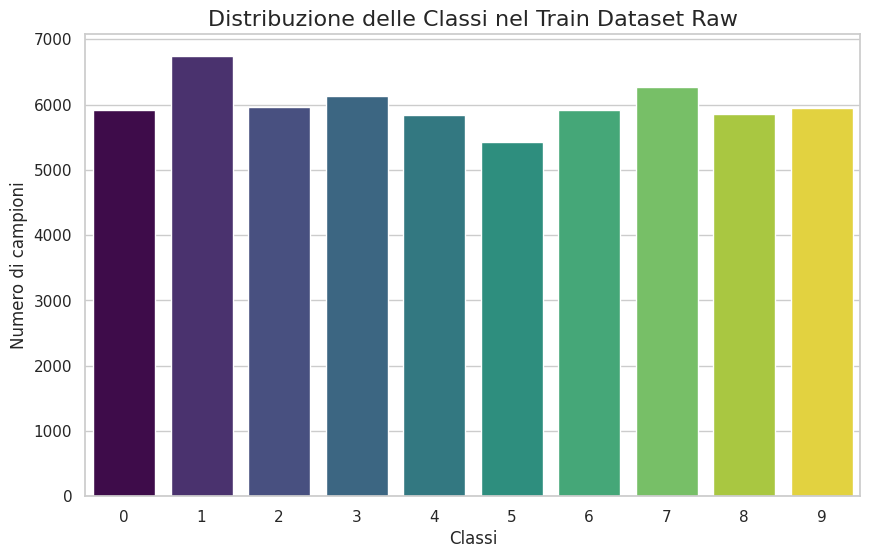

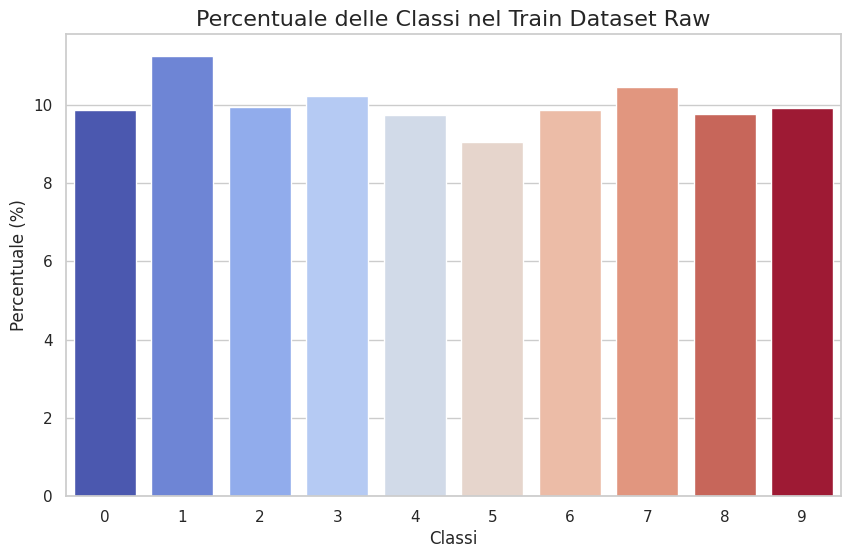

In [16]:
plot_dataset_raw_statistics(train_dataset_raw, "Train Dataset Raw")

Numero totale di campioni: 60000
Distribuzione delle relazioni (A > B, A < B, A = B): {1: 20000, 0: 20000, 2: 20000}
Dimensioni delle immagini trovate nel dataset: img_A -> torch.Size([1, 32, 32]) img_B -> torch.Size([1, 32, 32])
Relazione 1: 20000 campioni (33.33%)
Relazione 0: 20000 campioni (33.33%)
Relazione 2: 20000 campioni (33.33%)




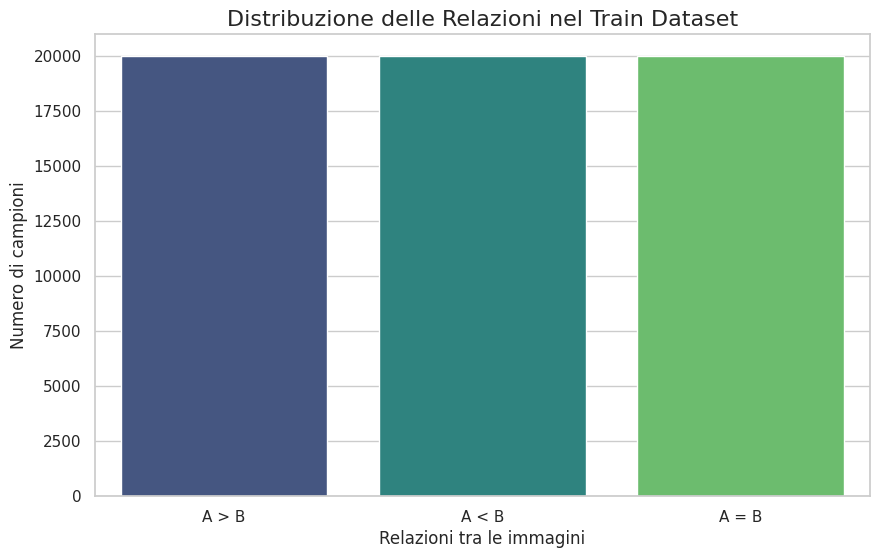

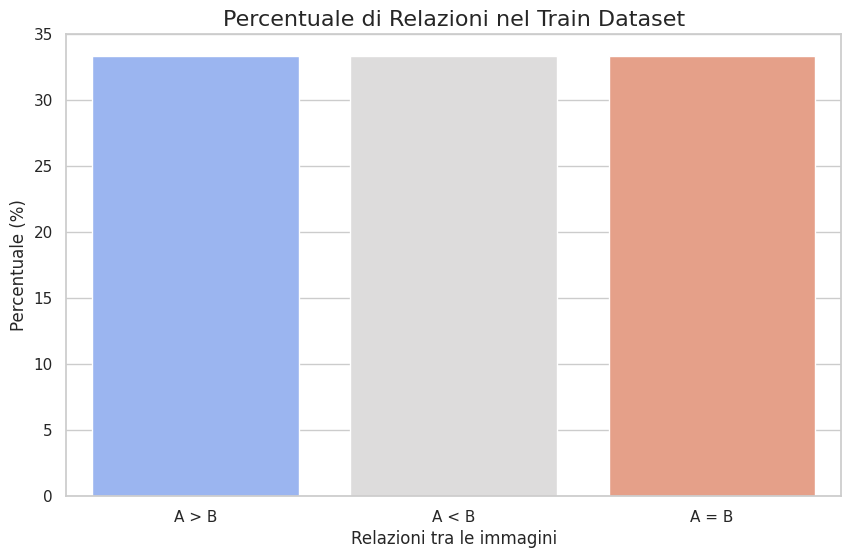

In [17]:
plot_dataset_statistics(train_dataset, dataset_name="Train Dataset")

Numero totale di campioni: 7000
Distribuzione delle relazioni (A > B, A < B, A = B): {2: 2374, 0: 2299, 1: 2327}
Dimensioni delle immagini trovate nel dataset: img_A -> torch.Size([1, 32, 32]) img_B -> torch.Size([1, 32, 32])
Relazione 2: 2374 campioni (33.91%)
Relazione 0: 2299 campioni (32.84%)
Relazione 1: 2327 campioni (33.24%)




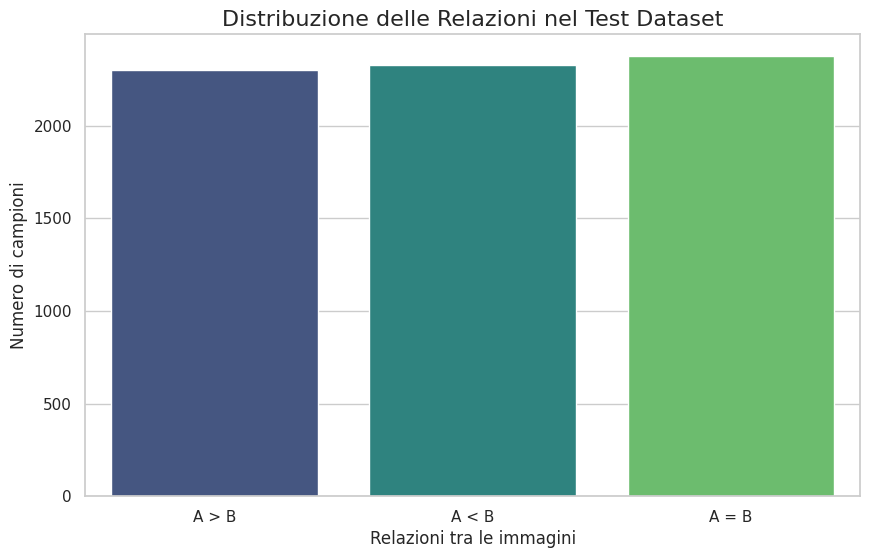

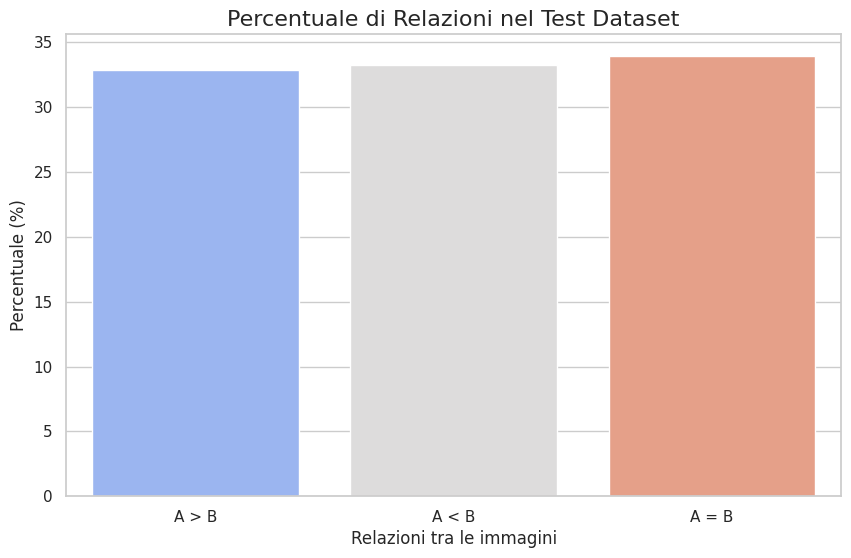

In [18]:
plot_dataset_statistics(test_dataset, dataset_name="Test Dataset")

Numero totale di campioni: 2999
Distribuzione delle relazioni (A > B, A < B, A = B): {1: 1006, 0: 1034, 2: 959}
Dimensioni delle immagini trovate nel dataset: img_A -> torch.Size([1, 32, 32]) img_B -> torch.Size([1, 32, 32])
Relazione 1: 1006 campioni (33.54%)
Relazione 0: 1034 campioni (34.48%)
Relazione 2: 959 campioni (31.98%)




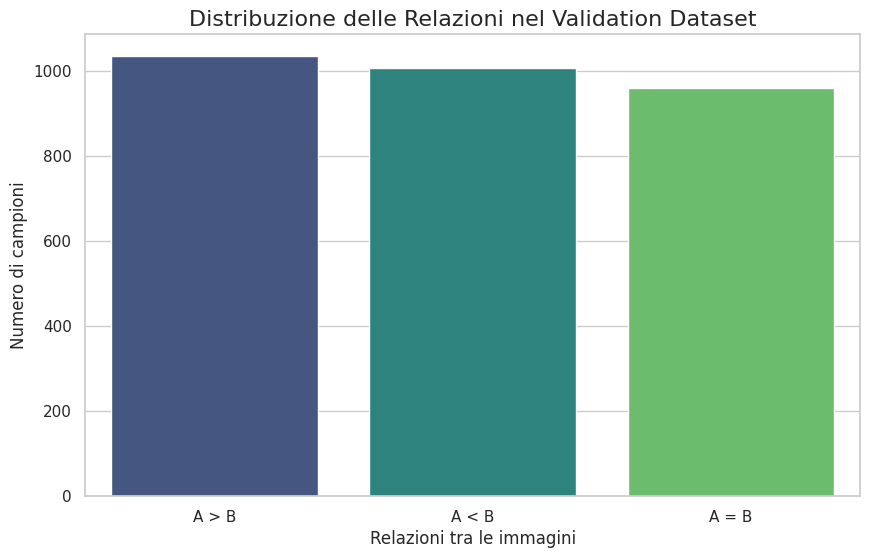

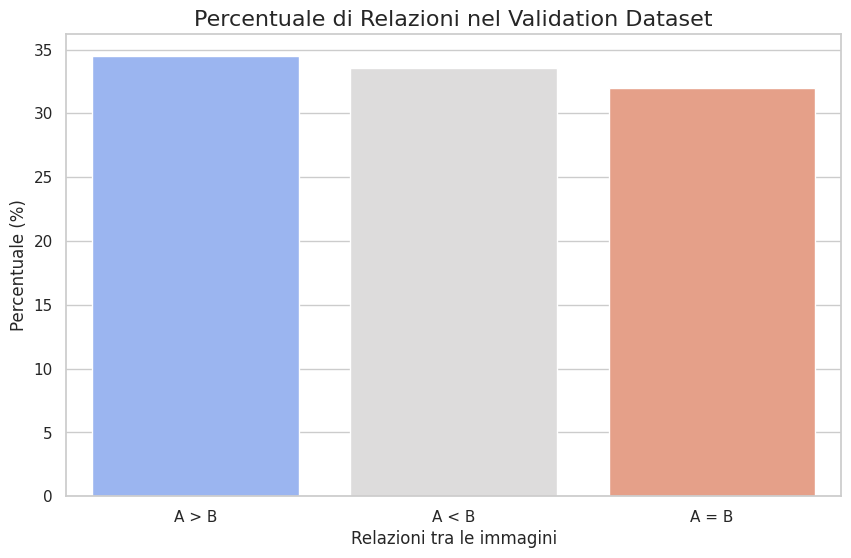

In [19]:
plot_dataset_statistics(validation_dataset, dataset_name="Validation Dataset")

In [20]:
train_loader, validation_loader, test_loader = create_data_loader(train_dataset, validation_dataset, test_dataset, BATCH_SIZE)

In [21]:
print("Size train_loader: ", len(train_loader), " Size train_dataset: ", len(train_dataset))
print("Size validation_loader: ", len(validation_loader), " Size validation_dataset: ", len(validation_dataset))
print("Size test_loader: ", len(test_loader), " Size test_dataset: ", len(test_dataset))

Size train_loader:  469  Size train_dataset:  60000
Size validation_loader:  24  Size validation_dataset:  2999
Size test_loader:  55  Size test_dataset:  7000


In [98]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [99]:
import torch.nn as nn
import torch.nn.functional as F

class NumberRecognitionCNN(nn.Module):
    def __init__(self):
        super(NumberRecognitionCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)  # Singola immagine, quindi 1 canale
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)  # 10 classi per i numeri da 0 a 9

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # Output con 10 classi (softmax potrebbe essere applicato esternamente)
        return x


In [100]:
class ComparisonMLP(nn.Module):
    def __init__(self):
        super(ComparisonMLP, self).__init__()
        self.fc1 = nn.Linear(2, 64)  # Prende 2 numeri in input
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 3)  # 3 classi (A > B, A < B, A = B)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # Output con 3 classi
        return x


In [101]:
class NumberComparisonModel(nn.Module):
    def __init__(self):
        super(NumberComparisonModel, self).__init__()
        self.cnn = NumberRecognitionCNN()  # Modello CNN per il riconoscimento dei numeri
        self.mlp = ComparisonMLP()  # MLP per confrontare i due numeri

    def load_cnn_weights(self, path):
        # Caricare i pesi della CNN da un file salvato
        self.cnn.load_state_dict(torch.load(path))
        # Bloccare i gradienti della CNN per non addestrarla nuovamente
        for param in self.cnn.parameters():
            param.requires_grad = False

    def forward(self, img1: torch.Tensor, img2: torch.Tensor):
        # Riconoscimento del numero in ciascuna immagine
        num1 = self.cnn(img1)
        num2 = self.cnn(img2)

        # Convertire l'output della CNN in numeri predetti
        num1 = F.softmax(num1, dim=1).argmax(dim=1)
        num2 = F.softmax(num2, dim=1).argmax(dim=1)

        # Convertire i numeri in tensori float per il confronto
        num1 = num1.float()
        num2 = num2.float()

        # Combinare i numeri riconosciuti per passarli alla MLP
        numbers = torch.stack((num1, num2), dim=1)
        comparison = self.mlp(numbers)
        return num1, num2, comparison


In [102]:
# define Loss and Optimizer
import torch.optim as optim

model = NumberComparisonModel()

model.load_cnn_weights('weights/lenet5_best_weights.pth')
model.to(device)

criterion = nn.CrossEntropyLoss()

if OPTIMIZER == 'SGD':
    optimizer = optim.SGD(model.mlp.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
elif OPTIMIZER == 'ADAM':
    optimizer = optim.Adam(model.mlp.parameters(), lr=LEARNING_RATE)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

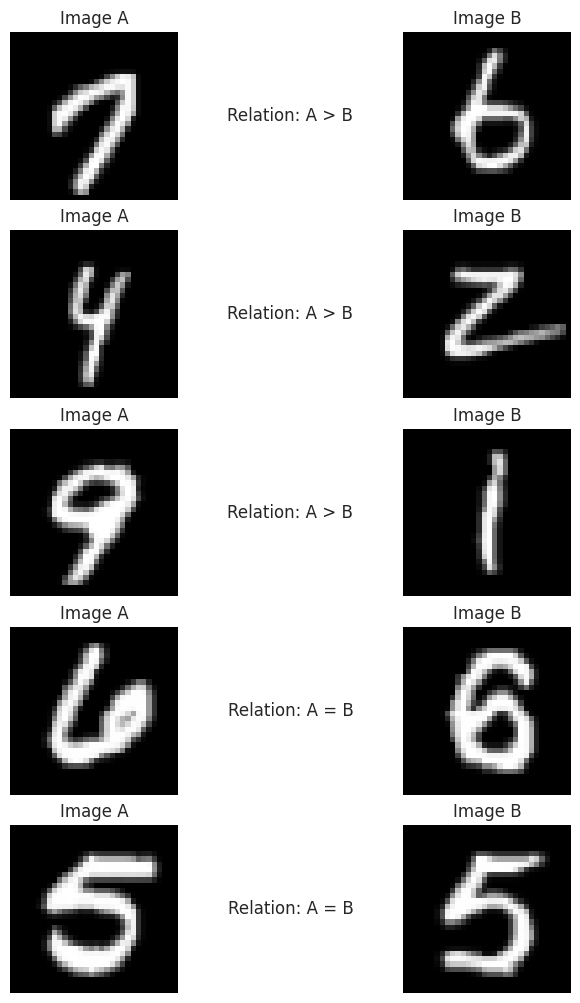

In [103]:
from torch.utils.tensorboard import SummaryWriter

# Definisci il fileName in base all'ottimizzatore
if OPTIMIZER == 'SGD':
    fileName = f"runs/logMLP_bs={BATCH_SIZE}_lr={LEARNING_RATE}_e={EPOCHS}_m={MOMENTUM}_aug={AUGMENT_DATASET}_tra={TRANSFORM_DATASET}_opt={OPTIMIZER}"
elif OPTIMIZER == 'ADAM':
    fileName = f"runs/logMLP_bs={BATCH_SIZE}_lr={LEARNING_RATE}_e={EPOCHS}_aug={AUGMENT_DATASET}_tra={TRANSFORM_DATASET}_opt={OPTIMIZER}"

writer = SummaryWriter(fileName)

# Ottieni un batch dal dataloader
batch = next(iter(train_loader))
imgs_A, imgs_B, labels = batch

# Dividi il batch in due immagini (img_A e img_B)
img_A, img_B = imgs_A[0], imgs_B[0]

# Ensure both tensors are of the same dtype
img_A = img_A.to(device)
img_B = img_B.to(device)

# Aggiungi entrambi gli input al grafo del modello
writer.add_graph(model, (img_A, img_B))


# Visualizza un esempio di coppia di immagini
writer.add_figure('Image_pair', show_dataset(train_loader, 5))


In [104]:
# define train and test functions
from tqdm import tqdm

def train(train_data_loader, model):
    print('Training')
    train_itr = 0
    correct_train = 0
    total_train = 0
    running_loss = 0.0
    train_loss_list = []
    train_accuracy_list = []
    
    # initialize tqdm progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))
    
    for i, data in enumerate(prog_bar):
        img_A, img_B, labels = data

        img_A, img_B, labels = img_A.to(device), img_B.to(device), labels.to(device)

        optimizer.zero_grad()

        num1, num2, outputs = model(img_A, img_B)
        _, predicted = torch.max(outputs, 1)

        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        loss_value = loss.item()
        running_loss += loss_value

        train_loss_list.append(loss_value)
        train_accuracy_list.append(100 * correct_train / total_train)

        train_itr += 1
    
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return running_loss / len(train_data_loader), 100 * correct_train / total_train, train_loss_list, train_accuracy_list

def validate(data_loader, model):
    print('Validating')
    val_itr = 0
    correct = 0
    total = 0
    running_loss = 0.0
    val_loss_list = []
    val_accuracy_list = []
    
    # initialize tqdm progress bar
    prog_bar = tqdm(data_loader, total=len(data_loader))
    
    for i, data in enumerate(prog_bar):
        img_A, img_B, labels = data

        img_A, img_B, labels = img_A.to(device), img_B.to(device), labels.to(device)
        
        with torch.no_grad():
            num1, num2, outputs = model(img_A, img_B)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        loss = criterion(outputs, labels)
        loss_value = loss.item()
        running_loss += loss_value
        val_loss_list.append(loss_value)
        val_accuracy_list.append(100 * correct / total)
        val_itr += 1
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return loss_value, 100 * correct / total, val_loss_list, val_accuracy_list

In [105]:
# TRAIN!!!
import time
model.train()
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
total_val_loss = []
total_val_acc = []
total_train_loss = []
total_train_acc = []
learning_rates = []
for epoch in range(EPOCHS):
        print(f"\nEPOCH {epoch+1} of {EPOCHS}")

        # start timer and carry out training and validation
        start = time.time()
        train_loss, train_acc, train_loss_list, train_acc_list = train(train_loader, model)
        val_loss, val_acc, val_loss_list, val_acc_list = validate(validation_loader, model)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        total_train_loss.extend(train_loss_list)
        total_train_acc.extend(train_acc_list)
        total_val_loss.extend(val_loss_list)
        total_val_acc.extend(val_acc_list)

        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        learning_rates.append(current_lr)
        
        print(f"Epoch #{epoch+1} train loss: {train_loss:.3f} train accuracy: {train_acc:.2f}")   
        print(f"Epoch #{epoch+1} validation loss: {val_loss:.3f} validation accuracy: {val_acc:.2f}")   
        end = time.time()
        print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch+1}")
        writer.add_scalars('Loss', {
                'Train': train_loss,
                'Validation': val_loss
        }, epoch + 1)
        
        writer.add_scalars('Accuracy', {
                'Train': train_acc,
                'Validation': val_acc
        }, epoch + 1)

# Valida il modello appena trainato con il test set
model.eval()
test_loss, test_acc, _, _ = validate(test_loader, model)
print(f"Test loss: {test_loss:.3f} Test accuracy: {test_acc:.2f}")
writer.add_scalar('Test Loss', test_loss)
writer.add_scalar('Test Accuracy', test_acc)



EPOCH 1 of 10
Training


Loss: 0.0077: 100%|██████████| 469/469 [00:09<00:00, 46.90it/s]


Validating


Loss: 0.2107: 100%|██████████| 24/24 [00:00<00:00, 43.50it/s]


Epoch #1 train loss: 0.186 train accuracy: 96.64
Epoch #1 validation loss: 0.211 validation accuracy: 99.20
Took 0.176 minutes for epoch 1

EPOCH 2 of 10
Training


Loss: 0.0032: 100%|██████████| 469/469 [00:10<00:00, 46.11it/s]


Validating


Loss: 0.2194: 100%|██████████| 24/24 [00:00<00:00, 54.23it/s]


Epoch #2 train loss: 0.016 train accuracy: 99.96
Epoch #2 validation loss: 0.219 validation accuracy: 99.20
Took 0.177 minutes for epoch 2

EPOCH 3 of 10
Training


Loss: 0.0023: 100%|██████████| 469/469 [00:10<00:00, 45.31it/s]


Validating


Loss: 0.1851: 100%|██████████| 24/24 [00:00<00:00, 53.75it/s]


Epoch #3 train loss: 0.013 train accuracy: 99.96
Epoch #3 validation loss: 0.185 validation accuracy: 99.20
Took 0.180 minutes for epoch 3

EPOCH 4 of 10
Training


Loss: 0.0014: 100%|██████████| 469/469 [00:10<00:00, 46.10it/s]


Validating


Loss: 0.1872: 100%|██████████| 24/24 [00:00<00:00, 52.72it/s]


Epoch #4 train loss: 0.011 train accuracy: 99.96
Epoch #4 validation loss: 0.187 validation accuracy: 99.20
Took 0.177 minutes for epoch 4

EPOCH 5 of 10
Training


Loss: 0.0014: 100%|██████████| 469/469 [00:10<00:00, 44.74it/s]


Validating


Loss: 0.1936: 100%|██████████| 24/24 [00:00<00:00, 51.15it/s]


Epoch #5 train loss: 0.010 train accuracy: 99.96
Epoch #5 validation loss: 0.194 validation accuracy: 99.20
Took 0.183 minutes for epoch 5

EPOCH 6 of 10
Training


Loss: 0.0010: 100%|██████████| 469/469 [00:10<00:00, 45.04it/s]


Validating


Loss: 0.2013: 100%|██████████| 24/24 [00:00<00:00, 51.48it/s]


Epoch #6 train loss: 0.008 train accuracy: 99.96
Epoch #6 validation loss: 0.201 validation accuracy: 99.20
Took 0.182 minutes for epoch 6

EPOCH 7 of 10
Training


Loss: 0.2036: 100%|██████████| 469/469 [00:09<00:00, 47.67it/s]


Validating


Loss: 0.1868: 100%|██████████| 24/24 [00:00<00:00, 52.62it/s]


Epoch #7 train loss: 0.008 train accuracy: 99.96
Epoch #7 validation loss: 0.187 validation accuracy: 99.20
Took 0.172 minutes for epoch 7

EPOCH 8 of 10
Training


Loss: 0.0009: 100%|██████████| 469/469 [00:09<00:00, 47.03it/s]


Validating


Loss: 0.1814: 100%|██████████| 24/24 [00:00<00:00, 52.48it/s]


Epoch #8 train loss: 0.007 train accuracy: 99.96
Epoch #8 validation loss: 0.181 validation accuracy: 99.20
Took 0.174 minutes for epoch 8

EPOCH 9 of 10
Training


Loss: 0.0011: 100%|██████████| 469/469 [00:10<00:00, 45.16it/s]


Validating


Loss: 0.1704: 100%|██████████| 24/24 [00:00<00:00, 51.86it/s]


Epoch #9 train loss: 0.006 train accuracy: 99.96
Epoch #9 validation loss: 0.170 validation accuracy: 99.20
Took 0.181 minutes for epoch 9

EPOCH 10 of 10
Training


Loss: 0.0007: 100%|██████████| 469/469 [00:10<00:00, 44.54it/s]


Validating


Loss: 0.2159: 100%|██████████| 24/24 [00:00<00:00, 49.57it/s]


Epoch #10 train loss: 0.006 train accuracy: 99.96
Epoch #10 validation loss: 0.216 validation accuracy: 99.20
Took 0.184 minutes for epoch 10
Validating


Loss: 0.2812: 100%|██████████| 55/55 [00:01<00:00, 31.51it/s]

Test loss: 0.281 Test accuracy: 98.99


In [106]:
def show_incorrect_predictions(model, dataloader, num_images=5):
    model.eval()
    all_images_A = []
    all_images_B = []
    all_labels = []
    all_preds = []
    all_num1_preds = []
    all_num2_preds = []

    # Itera su tutti i batch nel dataloader
    with torch.no_grad():
        for img_A, img_B, labels in dataloader:

            img_A, img_B, labels = img_A.to(device), img_B.to(device), labels.to(device)

            # Ottieni la predizione del numero per ogni immagine e la relazione
            num1_pred, num2_pred, relation_pred = model(img_A, img_B)
            _, predicted_relation = torch.max(relation_pred, 1)
            _, predicted_num1 = torch.max(num1_pred, 1)
            _, predicted_num2 = torch.max(num2_pred, 1)

            # Aggiungi i risultati a liste per visualizzarli
            all_images_A.append(img_A.cpu())
            all_images_B.append(img_B.cpu())
            all_labels.append(labels.cpu())
            all_preds.append(predicted_relation.cpu())
            all_num1_preds.append(predicted_num1.cpu())
            all_num2_preds.append(predicted_num2.cpu())

    # Concatena tutti i batch raccolti
    all_images_A = torch.cat(all_images_A)
    all_images_B = torch.cat(all_images_B)
    all_labels = torch.cat(all_labels)
    all_preds = torch.cat(all_preds)
    all_num1_preds = torch.cat(all_num1_preds)
    all_num2_preds = torch.cat(all_num2_preds)

    # Trova gli indici delle previsioni errate (sia comparazione che numeri errati)
    incorrect_predictions = (all_preds != all_labels).nonzero(as_tuple=True)[0]

    print(f"{len(incorrect_predictions)} previsioni errate trovate.")

    if len(incorrect_predictions) == 0:
        print("Nessuna previsione errata trovata.")
        return

    # Limita il numero di immagini errate da mostrare
    num_images = min(num_images, len(incorrect_predictions))

    fig, axes = plt.subplots(num_images, 4, figsize=(8, num_images * 2))
    relation_labels = {0: 'A > B', 1: 'A < B', 2: 'A = B'}
    
    for idx, i in enumerate(incorrect_predictions[:num_images]):
        img_A = all_images_A[i]
        img_B = all_images_B[i]
        pred_relation_label = all_preds[i].item()
        true_relation_label = all_labels[i].item()
        pred_num1 = all_num1_preds[i].item()
        pred_num2 = all_num2_preds[i].item()

        # Mostra l'immagine A
        axes[idx, 0].imshow(img_A, cmap='gray')
        axes[idx, 0].set_title(f'Image A (Pred: {pred_num1})')
        axes[idx, 0].axis('off')

        # Mostra l'etichetta di relazione prevista e reale
        axes[idx, 1].text(0.5, 0.5, f'Pred: {relation_labels[pred_relation_label]}\nTrue: {relation_labels[true_relation_label]}', 
                          fontsize=12, ha='center', va='center')
        axes[idx, 1].axis('off')

        # Mostra l'immagine B
        axes[idx, 2].imshow(img_B, cmap='gray')
        axes[idx, 2].set_title(f'Image B (Pred: {pred_num2})')
        axes[idx, 2].axis('off')

        # Mostra la predizione numerica e la relazione
        axes[idx, 3].text(0.5, 0.5, f'Pred: {pred_num1} vs {pred_num2}\nRel: {relation_labels[pred_relation_label]}', 
                          fontsize=12, ha='center', va='center')
        axes[idx, 3].axis('off')

    plt.tight_layout()
    plt.show()
    return fig

# Visualizza alcune previsioni errate
writer.add_figure('Incorrect_predictions', show_incorrect_predictions(model, validation_loader, num_images=10))


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

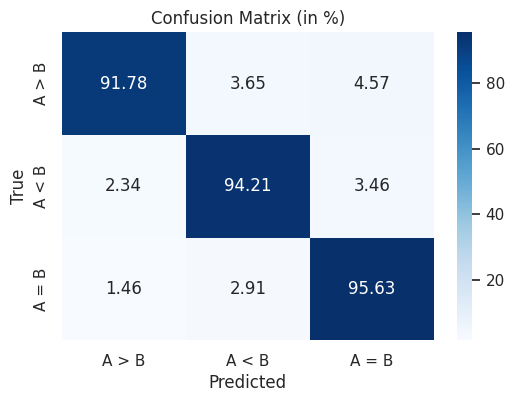

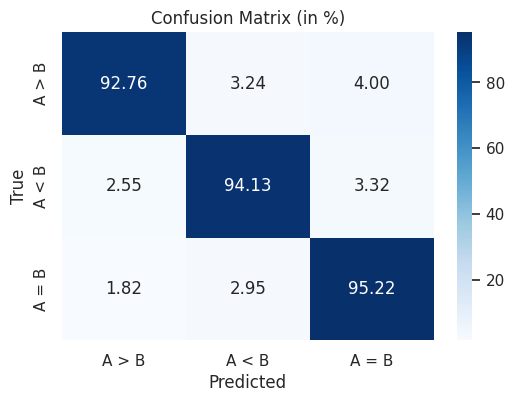

In [86]:
# Funzione per calcolare e stampare la matrice di confusione normalizzata
def plot_confusion_matrix(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    # Disabilita i gradienti per velocizzare il calcolo
    with torch.no_grad():
        for images, labels in dataloader:
            img_A = images[0, :, :]
            img_B = images[1, :, :]

            img_A, img_B, labels = img_A.to(device), img_B.to(device), labels.to(device)

            _, _, outputs = model(img_A, img_B)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Crea la matrice di confusione
    cm = confusion_matrix(all_labels, all_preds)
    
    # Normalizza la matrice di confusione
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalizza per ogni riga (classe vera)
    
    # Visualizza la matrice di confusione normalizzata in percentuale
    fig = plt.figure(figsize=(6, 4))
    sns.heatmap(cm_normalized * 100, annot=True, fmt=".2f", cmap="Blues", 
                xticklabels=['A > B', 'A < B', 'A = B'], 
                yticklabels=['A > B', 'A < B', 'A = B'])
    
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix (in %)')
    plt.show()

    return fig

# Calcola e visualizza la matrice di confusione
writer.add_figure('Confusion_matrix_validation', plot_confusion_matrix(model, validation_loader, device))
writer.add_figure('Confusion_matrix_test', plot_confusion_matrix(model, test_loader, device))
#plot_confusion_matrix(model, test_loader, device)


In [87]:
def classification_metrics(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    # Disabilita i gradienti per velocizzare il calcolo
    with torch.no_grad():
        for images, labels in dataloader:
            img_A = images[0, :, :]
            img_B = images[1, :, :]

            img_A, img_B, labels = img_A.to(device), img_B.to(device), labels.to(device)

            _, _, outputs = model(img_A, img_B)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Genera il report di classificazione
    report = classification_report(all_labels, all_preds, target_names=['A > B', 'A < B', 'A = B'])
    print(report)

# Stampa il report delle metriche
classification_metrics(model, test_loader, device)


              precision    recall  f1-score   support

       A > B       0.96      0.93      0.94      2348
       A < B       0.94      0.94      0.94      2349
       A = B       0.93      0.95      0.94      2303

    accuracy                           0.94      7000
   macro avg       0.94      0.94      0.94      7000
weighted avg       0.94      0.94      0.94      7000



Precision: Il numero di veri positivi diviso per il numero di esempi che sono stati predetti come positivi.
Recall (Sensibilità): Il numero di veri positivi diviso per il numero di esempi che appartengono effettivamente alla classe positiva.
F1-Score: La media armonica tra precisione e recall. È utile quando hai un dataset squilibrato.
Support: Il numero di campioni effettivi per ogni classe.

In [88]:
# Funzione per salvare una copia del notebook
def save_notebook_copy(notebook_name='main.ipynb'):
    # Leggi il notebook attuale
    with open(notebook_name, 'r') as f:
        notebook_content = nbformat.read(f, as_version=4)
    
    if OPTIMIZER == 'SGD':
        new_notebook_name = f"runMLP_BS={BATCH_SIZE}_LR={LEARNING_RATE}_MOM={MOMENTUM}_EPOCHS={EPOCHS}_AUG={AUGMENT_DATASET}_TRA={TRANSFORM_DATASET}_OPT={OPTIMIZER}.ipynb"
    elif OPTIMIZER == 'ADAM':
        new_notebook_name = f"runMLP_BS={BATCH_SIZE}_LR={LEARNING_RATE}_EPOCHS={EPOCHS}_AUG={AUGMENT_DATASET}_TRA={TRANSFORM_DATASET}_OPT={OPTIMIZER}.ipynb"
    
    # Salva il notebook con il nuovo nome
    with open(new_notebook_name, 'w') as f:
        nbformat.write(notebook_content, f)
    print(f"Notebook saved as {new_notebook_name}")

# Specifica il nome del notebook attuale
save_notebook_copy('main.ipynb')


Notebook saved as run_BS=128_LR=0.008_MOM=0.9_EPOCHS=30_AUG=False_TRA=False.ipynb


In [89]:
writer.close()